# Building Detection in Satellite Images

## Project Overview

### Introduction
This project focuses on analyzing satellite images to detect and mark buildings within these images. Using advanced data science techniques, the project automatically generates masks over the satellite images, highlighting the locations of the buildings.

### Objective
The primary objective of this project is to aid in disaster risk management by digitizing buildings in satellite imagery. This process is a crucial first step in humanitarian aid, as it helps identify which areas require more assistance in the aftermath of a disaster. While it might seem that most places are already mapped, the reality is different. Many regions, especially in developing countries, remain unmapped. These areas are often more vulnerable to disasters due to less resilient infrastructure. By providing accurate and up-to-date maps of these regions, our project aims to enhance disaster preparedness and response, ultimately contributing to saving lives and reducing the impact of disasters.  


## Methodology

### Data
The data for this project was sourced from the AIcrowd Mapping Challenge, available at [AIcrowd Mapping Challenge](https://www.aicrowd.com/challenges/mapping-challenge). This challenge provides a comprehensive dataset specifically designed for training and validating models aimed at satellite image analysis and building detection.  
  
#### Dataset Composition
The dataset consists of two main parts:

1. **Training Set (`train.tar.gz`):** This set includes 280,741 tiles, each being a 300x300 pixel RGB image of satellite imagery. These images are accompanied by annotations in the MS-COCO format, providing detailed information about the building locations within each tile.

2. **Validation Set (`val.tar.gz`):** The validation set comprises 60,317 tiles, also in the format of 300x300 pixel RGB satellite images. Similar to the training set, these images include corresponding annotations in MS-COCO format, allowing for effective model validation.

This dataset is instrumental in training our model to accurately detect and mark buildings in satellite imagery. The extensive number of images and the precision of the annotations provide a robust foundation for developing a model that can reliably identify buildings, which is essential for applications in disaster risk management and humanitarian aid.  


# Import libraries

In [1]:
from pycocotools.coco import COCO
import numpy as np
import random
import os
import shutil
import cv2
import requests
from PIL import Image
import matplotlib.gridspec as gridspec

## For visualizing results
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
import keras
from keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input, Cropping2D, ZeroPadding2D
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam

# Connect to Google Drive and load data

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
if not os.path.exists('/content/COCOdataset2017'):
  os.makedirs('/content/COCOdataset2017')

!tar -xzvf /content/drive/MyDrive/Flatiron_phase_5/8e089a94-555c-4d7b-8f2f-4d733aebb058_train.tar -C /content/COCOdataset2017
!tar -xzvf /content/drive/MyDrive/Flatiron_phase_5/0a5c561f-e361-4e9b-a3e2-94f42a003a2b_val.tar -C /content/COCOdataset2017

if not os.path.exists('/content/COCOdataset2017/images'):
  os.makedirs('/content/COCOdataset2017/images')
if not os.path.exists('/content/COCOdataset2017/annotations'):
  os.makedirs('/content/COCOdataset2017/annotations')

!mv /content/COCOdataset2017/train/annotation.json /content/COCOdataset2017/annotations/instances_train.json
!mv /content/COCOdataset2017/val/annotation.json /content/COCOdataset2017/annotations/instances_val.json

for folder in ['train', 'val']:
  src = os.path.join('/content/COCOdataset2017', folder, 'images')
  dst = os.path.join('/content/COCOdataset2017/images', folder)
  if not os.path.exists(dst):
    os.makedirs(dst)
  for file in os.listdir(src):
    shutil.move(os.path.join(src, file), os.path.join(dst, file))

Streaming output truncated to the last 5000 lines.
val/images/000000027550.jpg
val/images/000000037686.jpg
val/images/000000024847.jpg
val/images/000000002847.jpg
val/images/000000040101.jpg
val/images/000000020233.jpg
val/images/000000052688.jpg
val/images/000000031210.jpg
val/images/000000003710.jpg
val/images/000000042155.jpg
val/images/000000057830.jpg
val/images/000000010974.jpg
val/images/000000027856.jpg
val/images/000000048136.jpg
val/images/000000059940.jpg
val/images/000000000562.jpg
val/images/000000038403.jpg
val/images/000000057272.jpg
val/images/000000024676.jpg
val/images/000000017573.jpg
val/images/000000058259.jpg
val/images/000000051632.jpg
val/images/000000047488.jpg
val/images/000000042097.jpg
val/images/000000045608.jpg
val/images/000000027201.jpg
val/images/000000023912.jpg
val/images/000000056930.jpg
val/images/000000028737.jpg
val/images/000000039234.jpg
val/images/000000048587.jpg
val/images/000000007004.jpg
val/images/000000013987.jpg
val/images/000000025222.j

# EDA

In [ ]:
def loadDataset(annotation_path):
    coco = COCO(annotation_path)

    images = []

    # get all images
    imgIds = coco.getImgIds()
    images += coco.loadImgs(imgIds)

    random.shuffle(images)
    dataset_size = len(images)

    return images, dataset_size, coco

In [ ]:
train_annotation_path = r"/content/COCOdataset2017/annotations/instances_train.json"
train_images, train_dataset_size, train_coco = loadDataset(train_annotation_path)

val_annotation_path = r"/content/COCOdataset2017/annotations/instances_val.json"
val_images, val_dataset_size, val_coco = loadDataset(val_annotation_path)

loading annotations into memory...
Done (t=22.40s)
creating index...
index created!
loading annotations into memory...
Done (t=3.42s)
creating index...
index created!


The data has only one category, "building"

In [ ]:
print(f"training data has {train_dataset_size} images")
print(f"validation data has {val_dataset_size} images")

training data has 280741 images
validation data has 60317 images


## Sample image and mask

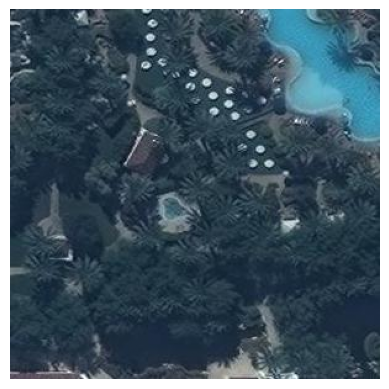

In [ ]:
imgIds = train_coco.getImgIds();
img = train_coco.loadImgs(imgIds[np.random.randint(0,len(imgIds))])[0]
image_path = '/content/COCOdataset2017/images/train/'+img['file_name']

I = Image.open(image_path)
I = np.array(I) / 255.0

plt.axis('off')
plt.imshow(I)
plt.show()

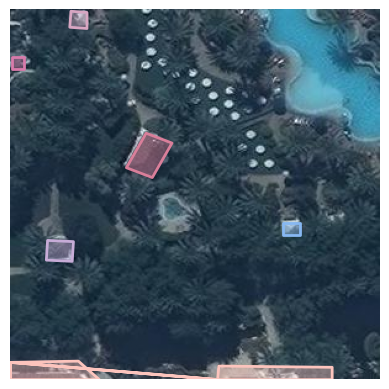

In [ ]:
plt.imshow(I); plt.axis('off')
catIds = train_coco.getCatIds()
annIds = train_coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
anns = train_coco.loadAnns(annIds)
train_coco.showAnns(anns)

# Creating the dataset

In [ ]:
def getImage(imageObj, img_folder, input_image_size):
    # Read and normalize an image
    train_img = Image.open((img_folder + '/' + imageObj['file_name']))
    train_img = np.array(train_img) / 255.0
    # Resize
    train_img = cv2.resize(train_img, input_image_size)
    return train_img

def getBinaryMask(imageObj, coco, input_image_size):
    annIds = coco.getAnnIds(imageObj['id'], iscrowd=None)
    anns = coco.loadAnns(annIds)
    train_mask = np.zeros(input_image_size)
    for a in range(len(anns)):
        new_mask = cv2.resize(coco.annToMask(anns[a]), input_image_size)

        #Threshold because resizing may cause extraneous values
        new_mask[new_mask >= 0.5] = 1
        new_mask[new_mask < 0.5] = 0

        train_mask = np.maximum(new_mask, train_mask)

    # Add extra dimension for parity with train_img size [X * X * 3]
    train_mask = train_mask.reshape(input_image_size[0], input_image_size[1], 1)
    return train_mask

def dataGeneratorCoco(images, coco, img_folder, input_image_size=(254,254), batch_size=8, BACKBONE=None):

    dataset_size = len(images)

    c = 0
    while(True):
        img = np.zeros((batch_size, input_image_size[0], input_image_size[1], 3)).astype('float')
        mask = np.zeros((batch_size, input_image_size[0], input_image_size[1], 1)).astype('float')

        for i in range(c, c+batch_size): #initially from 0 to batch_size, when c = 0
            imageObj = images[i]

            ### Retrieve Image ###
            train_img = getImage(imageObj, img_folder, input_image_size)

            ### Create Mask ###
            train_mask = getBinaryMask(imageObj, coco, input_image_size)

            # Add to respective batch sized arrays
            img[i-c] = train_img
            mask[i-c] = train_mask

        c+=batch_size
        if(c + batch_size >= dataset_size):
            c=0
            random.shuffle(images)
        if BACKBONE==None:
          yield img, mask
        else:
          preprocess_input = sm.get_preprocessing(BACKBONE)
          yield preprocess_input(img), preprocess_input(mask)

def visualizeGenerator(gen):
    img, mask = next(gen)

    fig = plt.figure(figsize=(20, 10))
    outerGrid = gridspec.GridSpec(1, 2, wspace=0.1, hspace=0.1)

    for i in range(2):
        innerGrid = gridspec.GridSpecFromSubplotSpec(2, 2,
                        subplot_spec=outerGrid[i], wspace=0.05, hspace=0.05)

        for j in range(4):
            ax = plt.Subplot(fig, innerGrid[j])
            if(i==1):
                ax.imshow(img[j])
            else:
                ax.imshow(mask[j][:,:,0], cmap='gray')

            ax.axis('off')
            fig.add_subplot(ax)
    plt.show()

In [ ]:
train_img_folder = r"/content/COCOdataset2017/images/train"
val_img_folder = r"/content/COCOdataset2017/images/val"

train_gen = dataGeneratorCoco(train_images, train_coco, train_img_folder, input_image_size=(256, 256), batch_size=8, BACKBONE=None)
val_gen = dataGeneratorCoco(val_images, val_coco, val_img_folder, input_image_size=(256, 256), batch_size=8, BACKBONE=None)

train_batch_images, train_batch_masks = next(train_gen)
val_batch_images, val_batch_masks = next(val_gen)

In [ ]:
print("The shape of an image batch is:",train_batch_images.shape)
print("The shape of a mask batch is:",train_batch_masks.shape)

The shape of an image batch is: (8, 256, 256, 3)
The shape of a mask batch is: (8, 256, 256, 1)


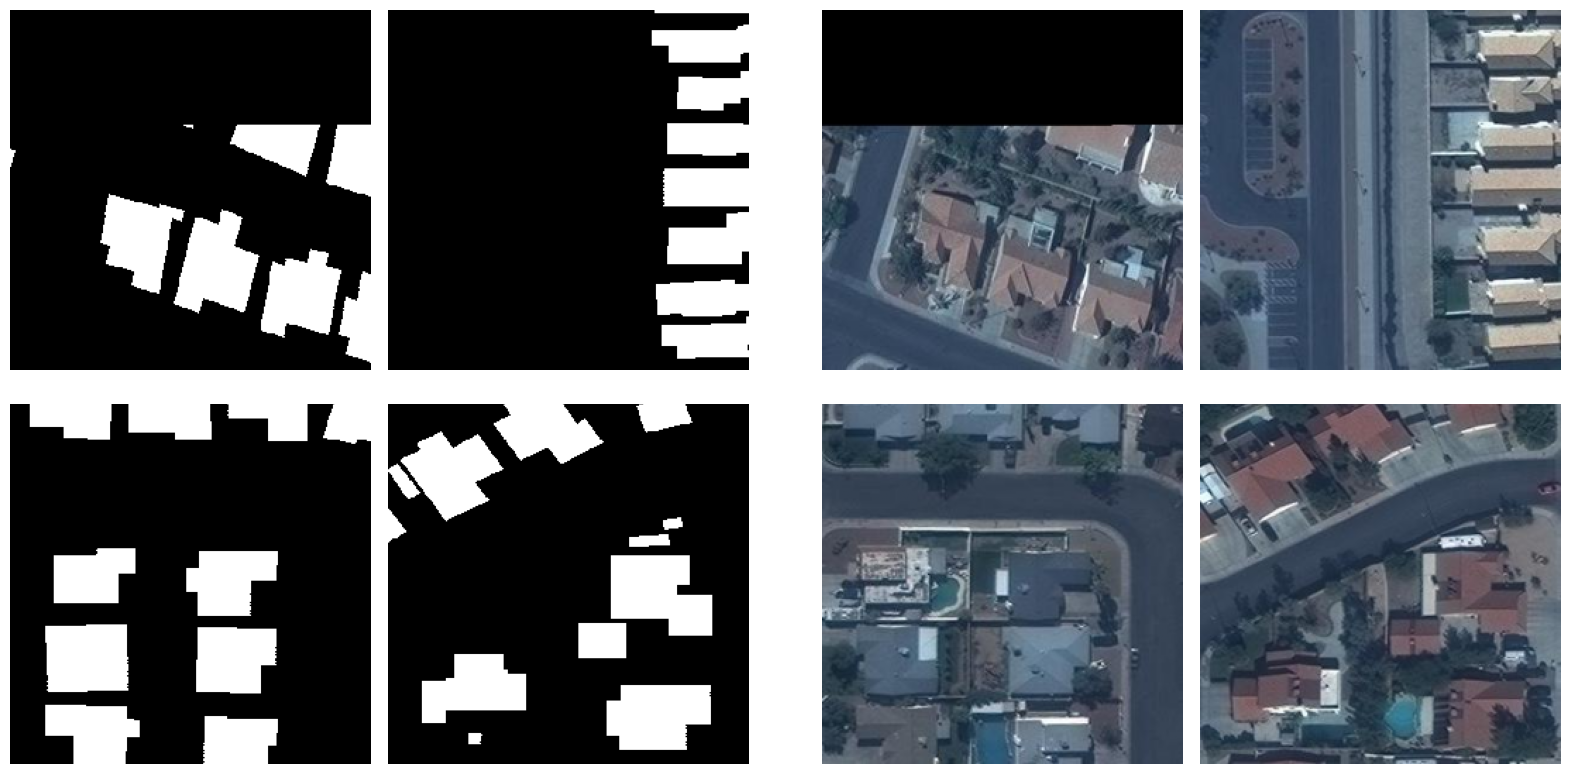

In [ ]:
visualizeGenerator(val_gen)

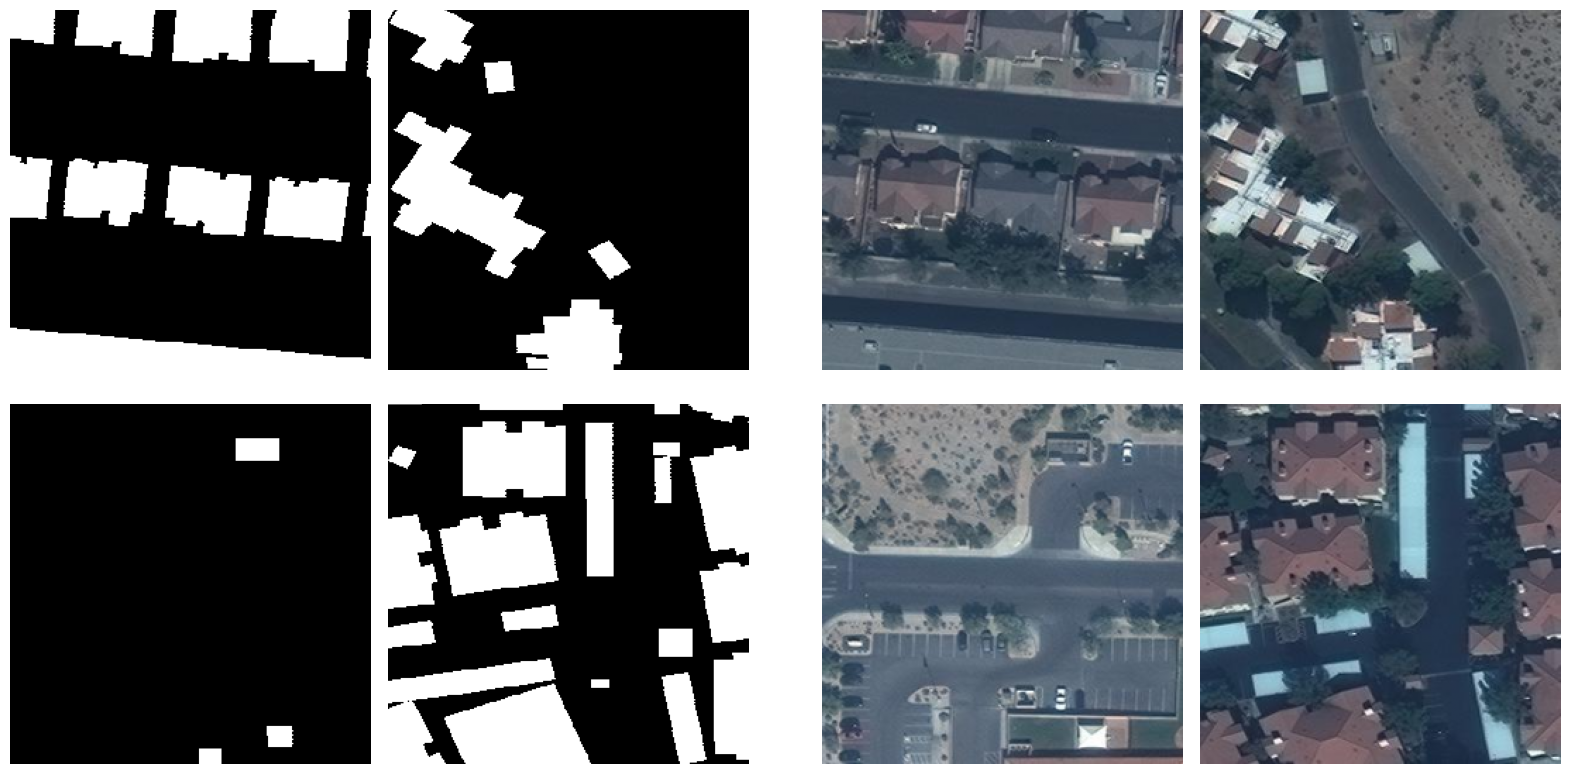

In [ ]:
visualizeGenerator(train_gen)

# Baseline Model

In [ ]:
def conv_block(inputs, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def encoder_block(inputs, num_filters):
    x = conv_block(inputs, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

def decoder_block(inputs, skip, num_filters):
     # Use 'same' padding for the Conv2DTranspose layer, (3, 3) kernel size, and (2, 2) strides
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(inputs)
    x = Concatenate()([x, skip])
    x = conv_block(x, num_filters)
    return x

def build_unet(input_shape):
    inputs = Input(input_shape)

    """Encoder"""
    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)

    """Bridge"""
    b1 = conv_block(p3, 512)

    """Decoder"""
    d1 = decoder_block(b1, s3, 256)
    d2 = decoder_block(d1, s2, 128)
    d3 = decoder_block(d2, s1, 64)


    outputs = Conv2D(1, 1, padding='same', activation='sigmoid')(d3)

    model = Model(inputs, outputs, name='UNET')
    return model

In [ ]:
input_shape = (256, 256, 3)
baseline_model = build_unet(input_shape)

In [ ]:
lr = 1e-4
opt = keras.optimizers.Adam(lr)
baseline_model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["acc", 'Precision'])

In [ ]:
print(baseline_model.summary())

Model: "UNET"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 256, 256, 64)         256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 256, 256, 64)         0         ['batch_normalization[0][0]

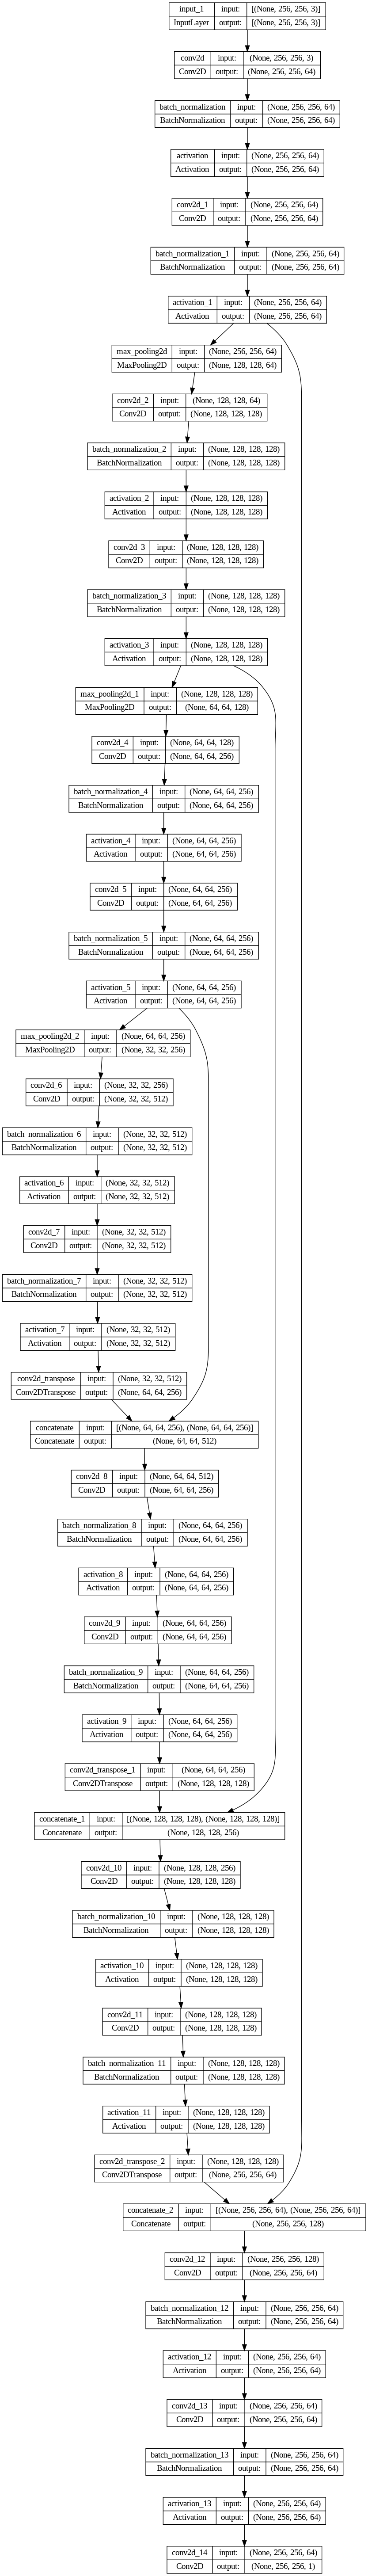

In [ ]:
from keras.utils import plot_model
plot_model(baseline_model, show_shapes=True)


In [ ]:
steps_per_epoch = 280741 // 8
validation_steps = 60317  // 8

history = baseline_model.fit(train_gen,
                validation_data = val_gen,
                steps_per_epoch = steps_per_epoch,
                validation_steps = validation_steps,
                epochs = 5,
                verbose = True)

Epoch 1/5
35092/35092 [==============================] - 4484s 127ms/step - loss: 0.1350 - acc: 0.9472 - precision: 0.8968 - val_loss: 0.1150 - val_acc: 0.9552 - val_precision: 0.8972
Epoch 2/5
35092/35092 [==============================] - 4479s 128ms/step - loss: 0.0986 - acc: 0.9612 - precision: 0.9206 - val_loss: 0.0973 - val_acc: 0.9614 - val_precision: 0.9090
Epoch 3/5
35092/35092 [==============================] - 4496s 128ms/step - loss: 0.0881 - acc: 0.9650 - precision: 0.9269 - val_loss: 0.0906 - val_acc: 0.9641 - val_precision: 0.9342
Epoch 4/5
35092/35092 [==============================] - 4479s 128ms/step - loss: 0.0808 - acc: 0.9676 - precision: 0.9313 - val_loss: 0.0818 - val_acc: 0.9676 - val_precision: 0.9330
Epoch 5/5
35092/35092 [==============================] - 4485s 128ms/step - loss: 0.0747 - acc: 0.9697 - precision: 0.9351 - val_loss: 0.0810 - val_acc: 0.9674 - val_precision: 0.9343


In [ ]:
baseline_model.save("/content/drive/MyDrive/Flatiron_phase_5/Final models/baseline model")

### Accuracy and precision plots

NameError: ignored

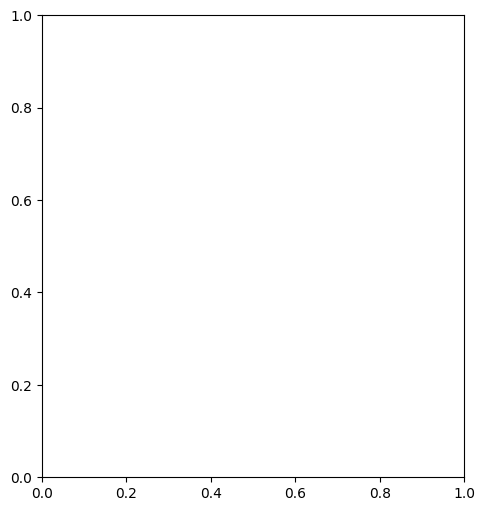

In [ ]:
# Plotting Accuracy
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['acc'], label='Train Accuracy')
plt.plot(history.history['val_acc'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

# Plotting Precision
plt.subplot(1, 2, 2)
plt.plot(history.history['precision'], label='Train Precision')
plt.plot(history.history['val_precision'], label='Validation Precision')
plt.title('Model Precision')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()

### Loss Plot

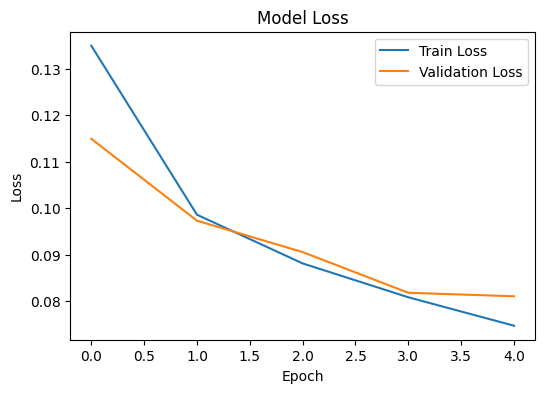

In [ ]:
plt.figure(figsize=(6, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

# Model 2 (pretrained model)

In [ ]:
!pip install segmentation-models

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.8 MB/s eta 0:00:00


In [ ]:
import segmentation_models as sm

Segmentation Models: using `keras` framework.


In [ ]:
n_classes=1
activation='sigmoid'
LR = 0.0001
optim = keras.optimizers.Adam(LR)
metrics = ["acc", 'Precision']

BACKBONE = 'resnet34'
loss = sm.losses.BinaryCELoss()

In [ ]:
model2 = sm.Unet(BACKBONE, encoder_weights='imagenet', classes=n_classes, activation=activation)
model2.compile(optim, loss, metrics=metrics)

85521592/85521592 [==============================] - 0s 0us/step


In [ ]:
print(model2.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 data (InputLayer)           [(None, None, None, 3)]      0         []                            
                                                                                                  
 bn_data (BatchNormalizatio  (None, None, None, 3)        9         ['data[0][0]']                
 n)                                                                                               
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, None, None, 3)        0         ['bn_data[0][0]']             
 g2D)                                                                                             
                                                                                            

In [ ]:
steps_per_epoch = 280741 // 8
validation_steps = 60317  // 8

history2=model2.fit(train_gen,
          epochs=10,
          steps_per_epoch = steps_per_epoch,
          validation_steps = validation_steps,
          verbose=1,
          validation_data=val_gen)

Epoch 1/10
35092/35092 [==============================] - 3197s 90ms/step - loss: 0.1102 - acc: 0.9567 - precision: 0.9115 - val_loss: 0.1014 - val_acc: 0.9595 - val_precision: 0.9039
Epoch 2/10
35092/35092 [==============================] - 3056s 87ms/step - loss: 0.0852 - acc: 0.9657 - precision: 0.9280 - val_loss: 0.0799 - val_acc: 0.9676 - val_precision: 0.9340
Epoch 3/10
35092/35092 [==============================] - 3130s 89ms/step - loss: 0.0767 - acc: 0.9687 - precision: 0.9337 - val_loss: 0.0749 - val_acc: 0.9695 - val_precision: 0.9385
Epoch 4/10
35092/35092 [==============================] - 3138s 89ms/step - loss: 0.0701 - acc: 0.9711 - precision: 0.9385 - val_loss: 0.0684 - val_acc: 0.9718 - val_precision: 0.9398
Epoch 5/10
35092/35092 [==============================] - 3205s 91ms/step - loss: 0.0645 - acc: 0.9731 - precision: 0.9425 - val_loss: 0.0645 - val_acc: 0.9734 - val_precision: 0.9467
Epoch 6/10
35092/35092 [==============================] - 3052s 87ms/step - loss

In [ ]:
model2.save("/content/drive/MyDrive/Flatiron_phase_5/Final models/pretrained model/pretrained_model_10_epoch.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


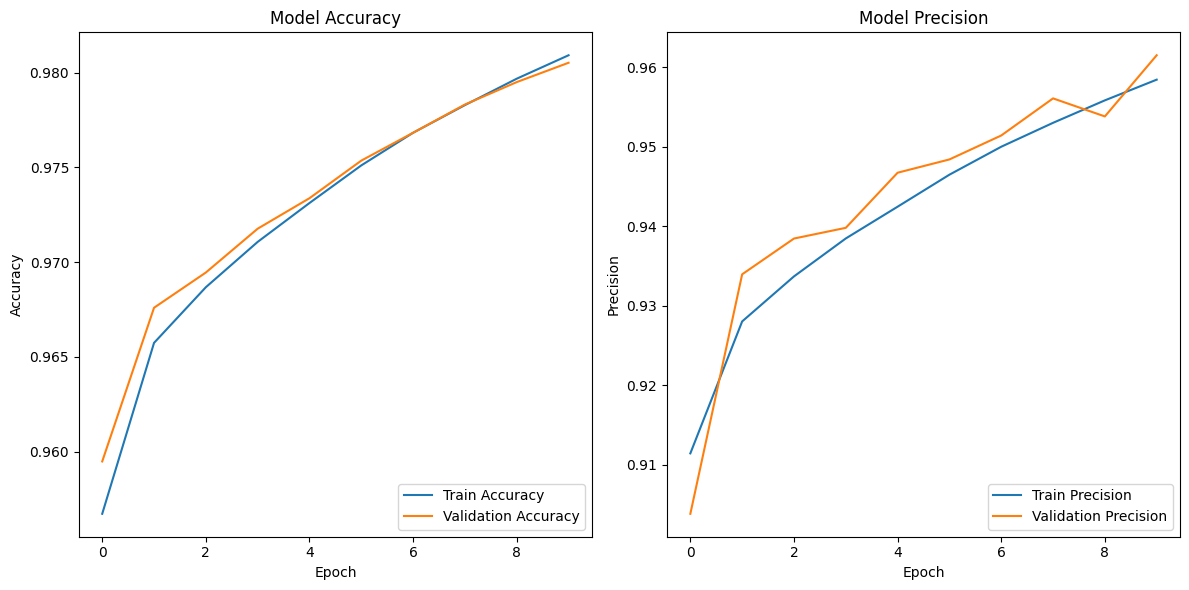

In [ ]:
# Plotting Accuracy
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history2.history['acc'], label='Train Accuracy')
plt.plot(history2.history['val_acc'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

# Plotting Precision
plt.subplot(1, 2, 2)
plt.plot(history2.history['precision'], label='Train Precision')
plt.plot(history2.history['val_precision'], label='Validation Precision')
plt.title('Model Precision')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()

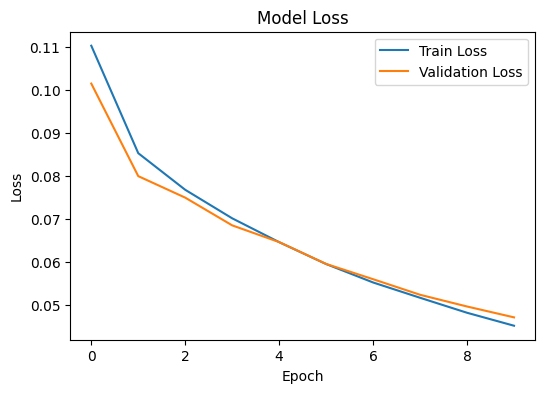

In [ ]:
plt.figure(figsize=(6, 4))
plt.plot(history2.history['loss'], label='Train Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

# Predictions

In [7]:
# Specify the path to the saved model file
drive_path = os.path.join('/content/drive', 'My Drive')

# Get the path to the trained models directory
trained_models_path = "/content/drive/MyDrive/Flatiron_phase_5/Final models/baseline model"

# Load the SavedModel
model = tf.keras.models.load_model(trained_models_path)
# Now, you can use the loaded_model for predictions or further training

1/1 [==============================] - 10s 10s/step


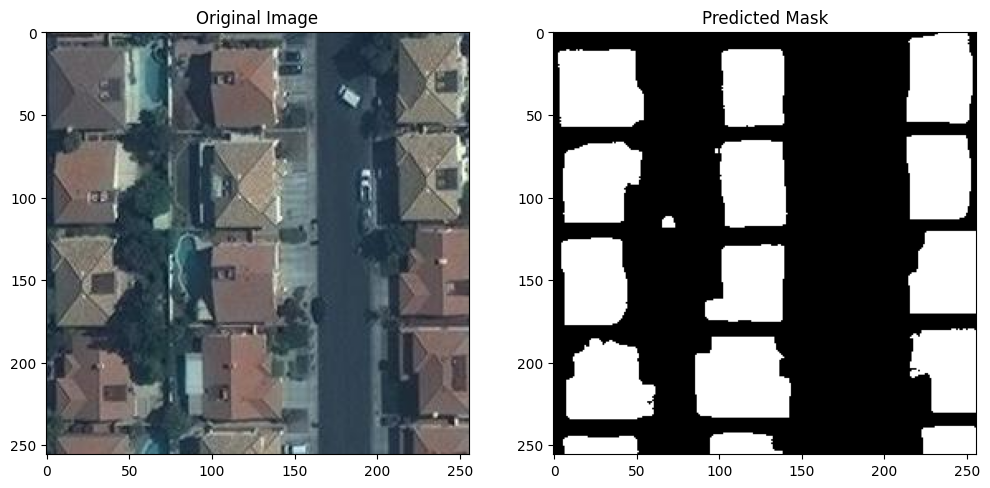

In [8]:
def read_image(path):
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
    x = x / 255.0
    return x

input_image_path = r"/content/drive/MyDrive/Flatiron_phase_5/test images/000000000016.jpg"
input_image = read_image(input_image_path)

# Perform model prediction
predictions = model.predict(np.expand_dims(input_image, axis=0))  # Expand dimensions to create batch size of 1

# Post-process the predictions to get a mask
threshold = 0.5 #adjust the threshold as needed
predicted_mask = (predictions > threshold).astype(np.uint8)[0]  # Convert to binary mask

# Plot the original image and the predicted mask side by side
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(input_image)
plt.title("Original Image")

plt.subplot(1, 2, 2)
plt.imshow(predicted_mask, cmap="gray")
plt.title("Predicted Mask")

plt.show()